# Testing one target

Normalized inverted_s_in: [1.         0.01010501 0.00505978 0.00934629]
[1.         0.01010501 0.00505978 0.00934629]
Normalized inverted_s_in: [1.         0.01024146 0.00454217 0.01059891]
[1.         0.01024146 0.00454217 0.01059891]
Normalized inverted_s_in: [1.         0.00930853 0.00394337 0.01023218]
[1.         0.00930853 0.00394337 0.01023218]
Normalized inverted_s_in: [1.         0.00999537 0.00519471 0.01011186]
[1.         0.00999537 0.00519471 0.01011186]
Normalized inverted_s_in: [1.         0.0103254  0.00516234 0.00990387]
[1.         0.0103254  0.00516234 0.00990387]
Normalized inverted_s_in: [1.         0.01018296 0.00442193 0.01023755]
[1.         0.01018296 0.00442193 0.01023755]
Normalized inverted_s_in: [1.         0.0105014  0.00558304 0.00977424]
[1.         0.0105014  0.00558304 0.00977424]
Normalized inverted_s_in: [1.         0.01023103 0.00470708 0.01055917]
[1.         0.01023103 0.00470708 0.01055917]
Normalized inverted_s_in: [1.         0.01013174 0.00474

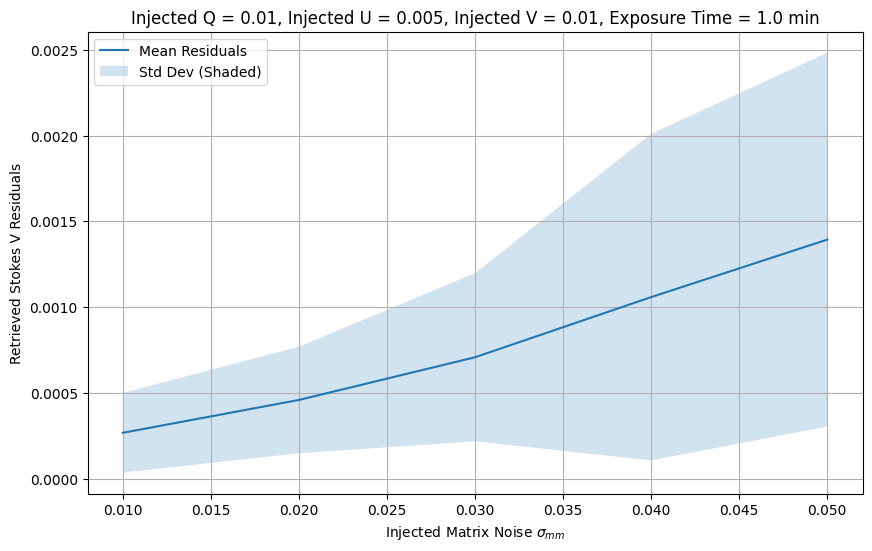

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../../python/')
import angles
import instrument_mm

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    # {"name": "Mirfak", "ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    # {"name": "Polaris", "ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST
matrix_noise_type = "additive"

# Fixed integration time and sub-integration time
t_int = 1 * 60  # 1 minute in seconds
sub_tint = 1  # 0.5 seconds
num_samples = 100

# Injected polarization
Q_injected = 0.01  # Injected Stokes Q
U_injected = 0.005  # Injected Stokes U-
V_injected = 0.01
noise_percentage = 0  # Intensity noise
include_V = True
normalize_s_out = True

# NOTE: For HWP
# delta_HWP = 0.5
# HWP_angs = np.array([0, 22.5, 45, 67.5])
# filename_tag = "HWP_regular_modulation"

# NOTE: For QWP
delta_HWP = 0.25
HWP_angs = [-3.17292985e+01, 3.17145088e+01, 2.23019936e-03, 5.82854763e+01]
filename_tag = "QWP_Katsu_Measurement_Matrix_Inverse_Cond_Num_Minimization"


# Matrix noise range
matrix_noise_range = np.arange(1, 6)  # From 1% to 5%
num_trials = 50  # Number of trials per noise level

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over matrix noise levels
    for matrix_noise in matrix_noise_range:
        residuals = []

        # Perform multiple trials for each noise level
        for trial in range(num_trials):
            S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                V=V_injected,
                delta_HWP=delta_HWP,
                HWP_angs = HWP_angs,
                noise_percentage=noise_percentage,
                include_V=include_V,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps = num_samples,
                matrix_noise_type = matrix_noise_type,
                normalize_s_out=normalize_s_out,  # Normalize S_in if needed
            )
            
            # Calculate retrieved polarization
            print(S_in_retrieved)
            Q_retrieved, U_retrieved, V_retrieved = S_in_retrieved[1], S_in_retrieved[2], S_in_retrieved[3]
            
            # Calculate absolute residuals on V
            residual = np.abs(V_retrieved - V_injected)
            residuals.append(residual)

        # Compute mean and standard deviation of residuals for this noise level
        mean_residuals.append(np.mean(residuals))
        std_residuals.append(np.std(residuals))

    # Plot the V residuals for this target
    plt.figure(figsize=(10, 6))
    mean_residuals = np.array(mean_residuals)
    std_residuals = np.array(std_residuals)
    plt.plot(matrix_noise_range / 100, mean_residuals, label=f"Mean Residuals")
    plt.fill_between(matrix_noise_range / 100, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel(r"Injected Matrix Noise $\sigma_{mm}$")
    plt.ylabel("Retrieved Stokes V Residuals")
    plt.title(
        f"Injected Q = {Q_injected}, Injected U = {U_injected}, Injected V = {V_injected}, Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()


In [6]:
import os
notebook_name = os.path.splitext(os.path.basename(__file__))[0] if '__file__' in globals() else 'QWP_V_residuals_varying_matrix_noise_Q_' + str(Q_injected) + '_U_' + str(U_injected) + '_V_' + str(V_injected)
output_dir = "../numpy_files"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, notebook_name + ".txt")

with open(output_path, "w") as f:
    f.write("matrix_noise, mean_residual, std_residual, target_name, target_ra, target_dec\n")
    for target in targets:
        for i, matrix_noise in enumerate(matrix_noise_range):
            f.write(f"{matrix_noise}, {mean_residuals[i]:.8f}, {std_residuals[i]:.8f}, {target['name']}, {target['ra']}, {target['dec']}\n")
print(f"Saved summary data to {output_path}")

Saved summary data to ../numpy_files/QWP_V_residuals_varying_matrix_noise_Q_0.01_U_0.005_V_0.01.txt


../numpy_files/QWP_V_residuals_varying_matrix_noise_Q_0.01_U_0.005_V_0.01.txt


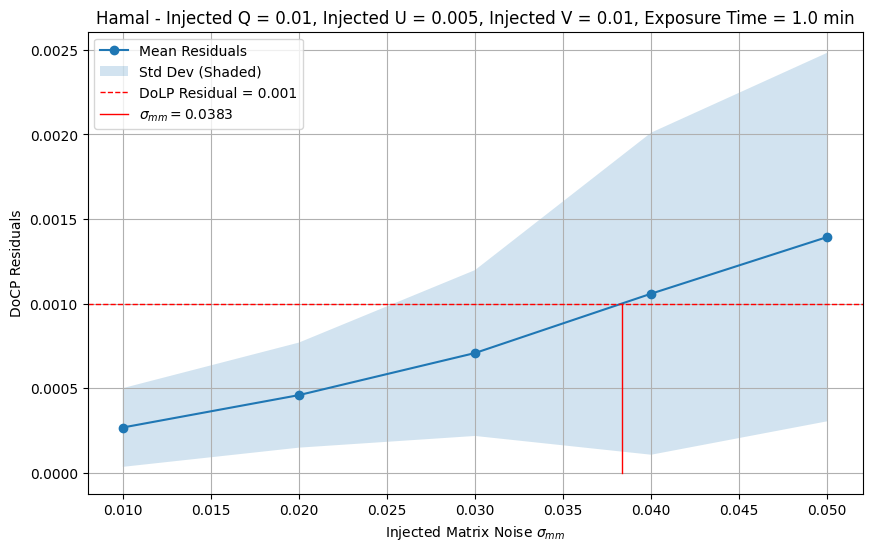

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
 ]

# Fixed parameters for plotting
notebook_name = os.path.splitext(os.path.basename(__file__))[0] if '__file__' in globals() else 'QWP_V_residuals_varying_matrix_noise_Q_' + str(Q_injected) + '_U_' + str(U_injected) + '_V_' + str(V_injected)
output_dir = "../numpy_files"
txt_path = os.path.join(output_dir, notebook_name + ".txt")

# Injected polarization
Q_injected = 0.01  # Injected Stokes Q
U_injected = 0.005  # Injected Stokes U-
V_injected = 0.01
noise_percentage = 0  # Intensity noise
include_V = True
normalize_s_out = True

print(txt_path)

# Read in the saved txt file
data = []
with open(txt_path, "r") as f:
    header = f.readline()  # skip header
    for line in f:
        parts = line.strip().split(",")
        if len(parts) < 6:
            continue
        matrix_noise = float(parts[0])
        mean_residual = float(parts[1])
        std_residual = float(parts[2])
        target_name = parts[3].strip()
        target_ra = float(parts[4])
        target_dec = float(parts[5])
        data.append((matrix_noise, mean_residual, std_residual, target_name, target_ra, target_dec))

data = np.array(data, dtype=object)

# Plot the results for each target
for target in targets:
    mask = data[:,3] == target['name']
    matrix_noise_range = data[mask,0].astype(float)
    mean_residuals = data[mask,1].astype(float)
    std_residuals = data[mask,2].astype(float)

    plt.figure(figsize=(10, 6))
    plt.plot(matrix_noise_range / 100, mean_residuals, '-o', label="Mean Residuals")
    plt.fill_between(matrix_noise_range / 100,
                     mean_residuals - std_residuals,
                     mean_residuals + std_residuals,
                     alpha=0.2, label="Std Dev (Shaded)")

    # Add dashed horizontal line with legend label
    plt.axhline(0.001, color='red', linestyle='--', linewidth=1, zorder=2,
                label="DoLP Residual = 0.001")

    # Find the x (matrix_noise/100) where mean_residuals crosses y=0.001
    from scipy.interpolate import interp1d
    try:
        f_interp = interp1d(mean_residuals, matrix_noise_range / 100,
                            kind='linear', bounds_error=False,
                            fill_value='extrapolate')
        x_at_y_0_001 = f_interp(0.001)

        if np.isfinite(x_at_y_0_001) and x_at_y_0_001 <= 0.05:
            plt.plot([x_at_y_0_001, x_at_y_0_001], [0, 0.001],
                     color='red', linestyle='-', linewidth=1, zorder=2,
                     label=fr"$\sigma_{{mm}} = {x_at_y_0_001:.4f}$")
    except Exception as e:
        print('Could not compute x at y=0.001:', e)

    plt.xlabel(r"Injected Matrix Noise $\sigma_{mm}$")
    plt.ylabel("DoCP Residuals")
    plt.title(
        f"{target['name']} - Injected Q = {Q_injected}, Injected U = {U_injected}, Injected V = {V_injected}, Exposure Time = 1.0 min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()
